# Real Estate Transactions Analysis

# Feature Information

- property_sub_type_en	- sub type of the property (ex. For units : apartment , shop , office ..etc)
- property_usage_ar	- property use based zoning authority's regulations (Residential , Commercial , Industrial .. Etc) in Arabic
- property_usage_en	- property use based zoning authority's regulations (Residential , Commercial , Industrial .. Etc)
- reg_type_id -	Type of registration (off-plan or existing properties)
- reg_type_ar	- Type of registration (off-plan or existing properties) in Arabic
- reg_type_en	- Type of registration (off-plan or existing properties)
- area_id	Area (community) ID
- area_name_ar	- community name in Arabic as per Dubai Municipality
- area_name_en	- community name in English as per Dubai Municipality
- transaction_id	- A Unique ID of the transaction
- procedure_id	- number generated through the system
- trans_group_id	- The unique ID of transaction group
- trans_group_ar	- high level group type of the transaction (Sales , Mortgages , Gifts)
- trans_group_en	- high level group type of the transaction (Sales , Mortgages , Gifts) in Arabic
- procedure_name_en	- Sub type of the transaction (pre-registration sale , delayed sale , update mortgage , - release mortgage ..etc)
- instance_date	- Transaction registration data
- project_number	- Developer's project number
- project_name_ar	- Developer's project Arabic name
- project_name_en	- Developer's project English name
- master_project_en	- master developer name in Arabic
- master_project_ar	- master developer name in English
- nearest_landmark_ar	- the nearest landmark to the property of the transaction in Arabic
- nearest_landmark_en	- the nearest landmark to the property of the transaction in English
- nearest_metro_ar	- the nearest metro station to the property of the transaction in Arabic
- nearest_metro_en	- the nearest metro station to the property of the transaction In English
- nearest_mall_ar	- the nearest mall to the property of the transaction in Arabic
- nearest_mall_en	- the nearest mall to the property of the transaction in English
- rooms_ar	- number of rooms in Arabic
- rooms_en	- number of room in English
- has_parking	- does the unit has a parking ? (0=No, 1=Yes)
- procedure_area	- The area (size) in suare meter on which the transaction was carried out
- actual_worth	- property price in the transaction
- meter_sale_price	- meter price in the transaction
- rent_value	- the mortgage value in lease to own procedures
- meter_rent_price	- the mortgage price per meter in lease to own procedures
- no_of_parties_role_1	- number of transaction's parties with first role (seller , mortgagor .. Etc )
- no_of_parties_role_2	- number of transaction's parties of second role (buyer , mortgagee .. Etc )
- no_of_parties_role_3	- number of transaction's parties of third role (lessee , usufrutor .. Etc )
- building_name_ar -	Building name in Arabic a given by the developer (not nessesarly to similar to common name)
- building_name_en -	Building name in English given by the developer (not nessesarly to similar to common name)
- procedure_name_ar -	Sub type of the transaction (pre-registration sale , delayed sale , update mortgage , release mortgage ..etc) in Arabic
- property_type_id -	number generated through the system
- property_type_ar -	main type of the property (land , Building , villa or unit) in Arabic
- property_type_en -	main type of the property (land , Building , villa or unit)
- property_sub_type_id -	PROPERTY_SUB_TYPE_ID
- property_sub_type_ar -	sub type of the property (ex. For units : apartment , shop , office ..etc) in Arabic

## Import Libraries and Load Dataset

In [1]:
# Install necessary libraries
!pip install missingno
!pip install squarify
!pip install xgboost

# Import libraries
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import missingno as msno
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import log_loss, accuracy_score
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from math import sqrt

%matplotlib inline

In [2]:
# Load the dataset
df = pd.read_csv('../Transactions.csv')

# Define target feature
target_feature = 'actual_worth'

## Data Exploration and Cleaning

### Explore the descriptive statistics of the variables

In [3]:
# Explore the descriptive statistics and information of the dataset
pd.set_option('display.float_format', lambda x: '%.3f' % x)


print("Dataset Information:")
print(df.info())

print("\nFirst few rows of the dataset:")
print(df.head())

print("\nSummary Statistics:")
print(df.describe(include='all'))

print("\nColumns in the dataset:")
print(df.columns)

print("\nShape of the dataset:")
print(df.shape)

Dataset Information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1184757 entries, 0 to 1184756
Data columns (total 46 columns):
 #   Column                Non-Null Count    Dtype  
---  ------                --------------    -----  
 0   transaction_id        1184757 non-null  object 
 1   procedure_id          1184757 non-null  int64  
 2   trans_group_id        1184757 non-null  int64  
 3   trans_group_ar        1184757 non-null  object 
 4   trans_group_en        1184757 non-null  object 
 5   procedure_name_ar     1184757 non-null  object 
 6   procedure_name_en     1184757 non-null  object 
 7   instance_date         1184757 non-null  object 
 8   property_type_id      1184757 non-null  int64  
 9   property_type_ar      1184757 non-null  object 
 10  property_type_en      1184757 non-null  object 
 11  property_sub_type_id  917032 non-null   float64
 12  property_sub_type_ar  917032 non-null   object 
 13  property_sub_type_en  917032 non-null   object 
 14  property_usag

### Determine the variables of interest

In [4]:
# Drop duplicate columns in Arabic
data = df.loc[:,~df.columns.str.endswith('_ar')]

In [5]:
# Drop columns
columns_to_drop = ['transaction_id', # random number assigned by authority
                    'procedure_id', # represents ids assigned to procedures, used to categorize 'procedure_name_en' values
                    'trans_group_id',  # represents ids assigned to transactions, used to categorize 'trans_group_name_en' values
                    'property_type_id', # represents ids assigned to property types, used to categorize 'property_type_en' values
                    'property_sub_type_id', # represents ids assigned to property sub-types, used to categorize 'property_sub_type_en' values
                    'reg_type_id', # represents ids assigned to property registration type, used to categorize 'reg_type_en' values
                    'area_id', # represents ids assigned to property area, used to categorize 'area_en' values
                    'project_number', # represents ids assigned to projects, used to categorize 'project_name_en' values
                    'no_of_parties_role_1', # feature is irrelevant
                    'no_of_parties_role_2', # feature is irrelevant
                    'no_of_parties_role_3', # feature is irrelevant
                    'property_type_en', # featue is irrelevant, since property sub-type feature is more descriptive
                    # 'meter_sale_price' # feature is derived from the actual_worth, not dropped yet, to be used in outlier detection
                   ]

data = data.drop(columns=columns_to_drop)

<Axes: >

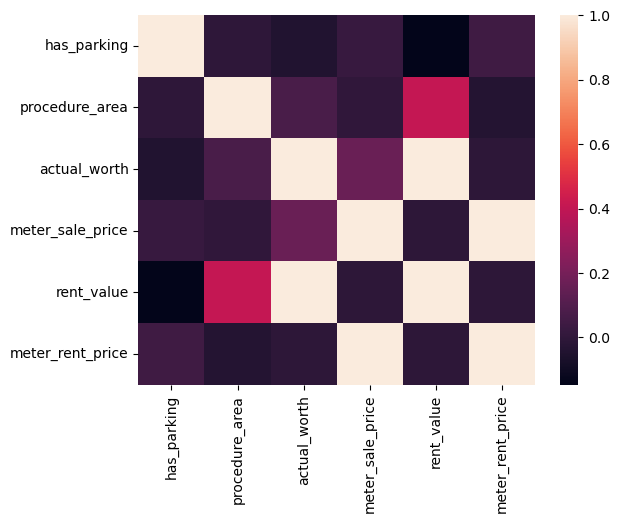

In [6]:
# calculate the correlation matrix on the numeric columns
corr = data.corr(numeric_only=True)

# plot the heatmap
sns.heatmap(corr)

In [7]:
# Convert 'instance_date' column to datetime
data['instance_date'] = pd.to_datetime(data['instance_date'], format='%d-%m-%Y', errors='coerce')

# Drop rows with invalid dates
data = data.dropna(subset=['instance_date'])

In [8]:
# Convert object columns to lowercase and replace spaces with underscores
object_cols = data.select_dtypes(include=['object']).columns
data[object_cols] = data[object_cols].apply(lambda x: x.str.lower().str.replace(' ', '_'))

[Text(0, 0, '890425'), Text(0, 0, '251384'), Text(0, 0, '42944')]

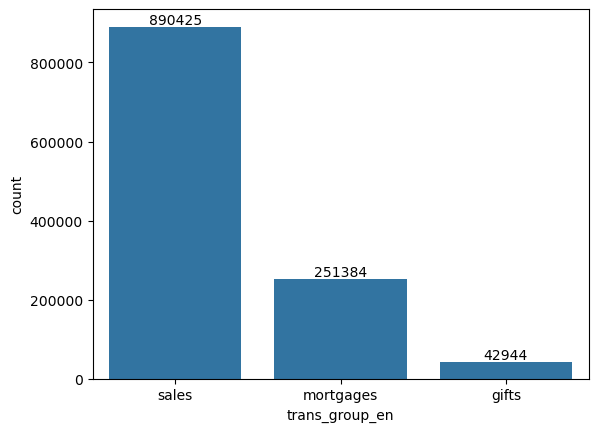

In [9]:
# Analyze transaction groups

ax = sns.countplot(data=data, x='trans_group_en', order=data['trans_group_en'].value_counts(ascending=False).index)
abs_values = data['trans_group_en'].value_counts(ascending=False).values
ax.bar_label(container=ax.containers[0], labels=abs_values)

In [10]:
# Remove observations of transaction type 'gifts' since they are irrelevant
data = data[data['trans_group_en'] != 'gifts']

In [11]:
# Analyze property_sub_type_en feature
print(data['property_sub_type_en'].value_counts())

flat                  683236
villa                  99926
office                 55883
hotel_apartment        23526
shop                   12412
hotel_rooms            11566
workshop                 481
stacked_townhouses       421
store                    319
building                 206
warehouse                130
clinic                    59
sized_partition           28
hotel                     26
show_rooms                18
gymnasium                 14
parking                    4
Name: property_sub_type_en, dtype: int64


In [12]:
# Remain only observations of specific property_sub_type_en
data = data[data['property_sub_type_en'].isin(['flat', 'villa', 'hotel_apartment', 'hotel_rooms', 'stacked_townhouses'])]

In [13]:
# Analyze rooms_en feature
data['rooms_en'].value_counts()

1_b/r          287762
2_b/r          210245
studio         149227
3_b/r          126960
4_b/r           36415
5_b/r            3532
penthouse        1601
single_room       738
6_b/r             188
shop               40
7_b/r              30
8_b/r               3
office              3
9_b/r               1
Name: rooms_en, dtype: int64

In [14]:
# Exclude properties of type 'office', 'shop' from dataset

data = data[~data['rooms_en'].isin(['office', 'shop'])]

In [15]:
# Replace b/r with bedroom in 'rooms_en' feature

data['rooms_en'] = data['rooms_en'].str.replace('b/r', 'bedroom')

## Handle outliers

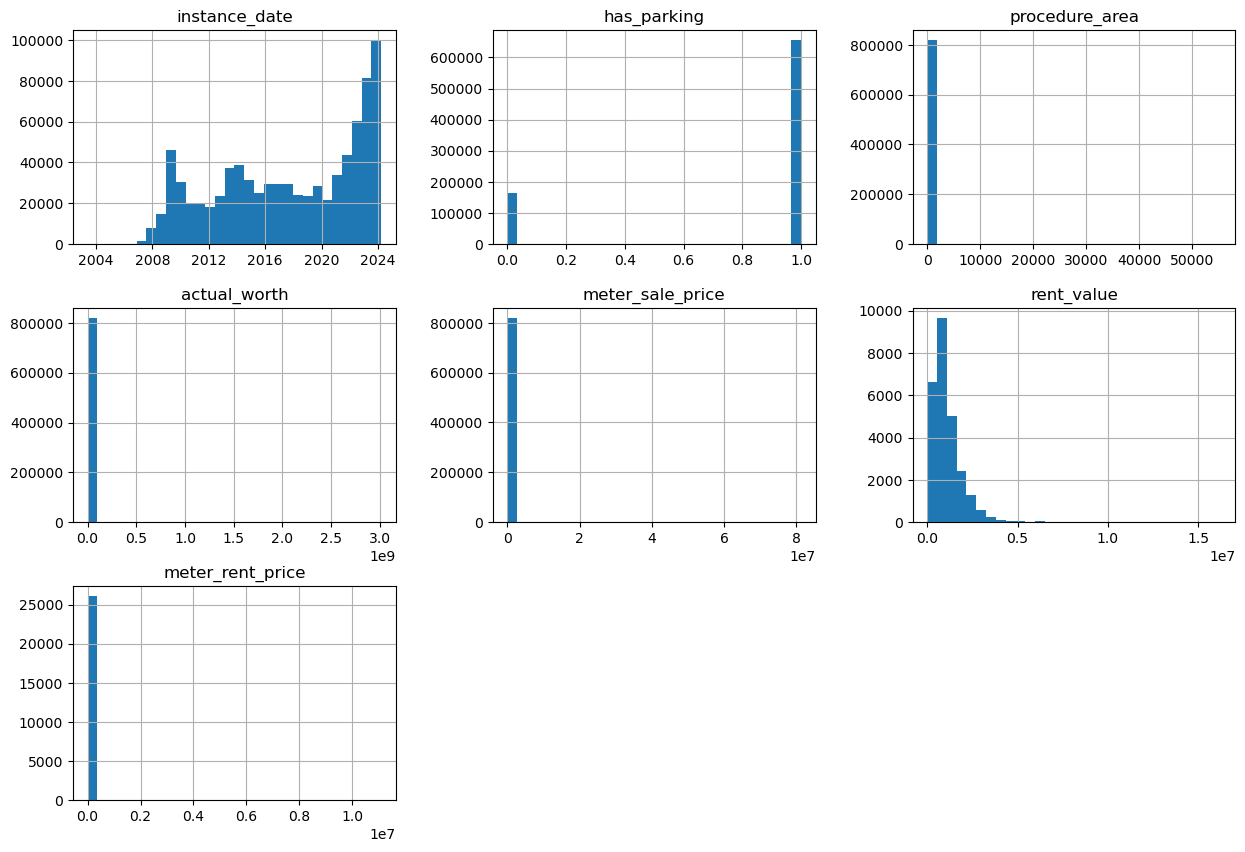

In [16]:
data.hist(bins=30, figsize=(15, 10))
plt.show()

**Minimum and Maximum Values for Outlier Detection**
- The Interquartile Range (IQR) is a measure of statistical dispersion, or spread, based on quartiles. Quartiles divide the dataset into four equal parts. The IQR is the range between the first quartile (Q1) and the third quartile (Q3).
- The minimum and maximum values for detecting outliers are calculated based on the IQR.
- In practice, the multiplier value of 1.5 is a commonly used default that strikes a balance between sensitivity to outliers and robustness to noise. 

In [17]:
def get_outliers_for_numerical_feature(df, feature):
    """
    Detect outliers for a given feature in the DataFrame.

    Parameters:
        df (DataFrame): The DataFrame containing the data.
        feature (str): The name of the feature for which outliers are to be detected.

    Returns:
        dict: A dictionary containing information about the outliers.
            - 'feature': The name of the feature.
            - 'iqr': The interquartile range (IQR) of the feature.
            - 'minimum': The lower bound for detecting outliers.
            - 'maximum': The upper bound for detecting outliers.
            - 'outliers': DataFrame containing the outliers.
    """

    # Handling missing values
    df = df.dropna(subset=[feature])

    # Calculate quartiles and interquartile range (IQR)
    q1 = df[feature].quantile(0.25)
    q2 = df[feature].median()
    q3 = df[feature].quantile(0.75)
    iqr = q3-q1

    # Calculate lower and upper bounds for outliers detection
    minimum = max(0, q1 - (1.5 * iqr)) # Set lower limit to 0 if it falls below 0
    maximum = (q3+(1.5*iqr))

    # Identify outliers using the bounds
    cond1 = df[feature]<minimum
    cond2 = df[feature]>maximum
    outliers = df[cond1 | cond2]

    # Return information about the outliers
    return {
        'feature': feature,
        'iqr': iqr,
        'minimum': minimum,
        'maximum': maximum,
        'outliers': outliers
    }
outliers = get_outliers_for_numerical_feature(data, 'procedure_area')
print(outliers)

{'feature': 'procedure_area', 'iqr': 84.08, 'minimum': 0, 'maximum': 275.25, 'outliers':         trans_group_en          procedure_name_en instance_date  \
8            mortgages  lease_to_own_registration    2012-04-23   
18           mortgages       development_mortgage    2020-10-19   
37               sales                       sell    2013-03-07   
65               sales                       sell    2020-12-21   
85           mortgages      mortgage_registration    2022-02-14   
...                ...                        ...           ...   
1184568          sales                       sell    2009-06-18   
1184578      mortgages       development_mortgage    2018-11-22   
1184612          sales    sell_-_pre_registration    2017-03-06   
1184627          sales    sell_-_pre_registration    2015-09-29   
1184741          sales    sell_-_pre_registration    2023-05-31   

        property_sub_type_en property_usage_en          reg_type_en  \
8                       flat       

In [18]:
# Take 99 percentiles for 'actual_worth' and keep all the values that are below it 
# Take 99 percentiles for 'meter_sale_price' and keep all the values that are below it
# Take 4 percentiles for 'instance_date' and keep all the values that are higher
# Take 99 percentiles for 'procedure_area' and keep all the values that are below it

# Compute quantiles for outlier detection
quantiles_actual_worth = data['actual_worth'].quantile(0.98)
quantiles_meter_sale_price = data['meter_sale_price'].quantile(0.99)
quantiles_instance_date = data['instance_date'].quantile(0.04)
quantiles_procedure_area = data['procedure_area'].quantile(0.99)
# Filter data to remove outliers
data = data[(data['actual_worth'] < quantiles_actual_worth) & 
            (data['meter_sale_price'] < quantiles_meter_sale_price) &
            (data['procedure_area'] < quantiles_procedure_area) &
            (data['instance_date'] > quantiles_instance_date)]

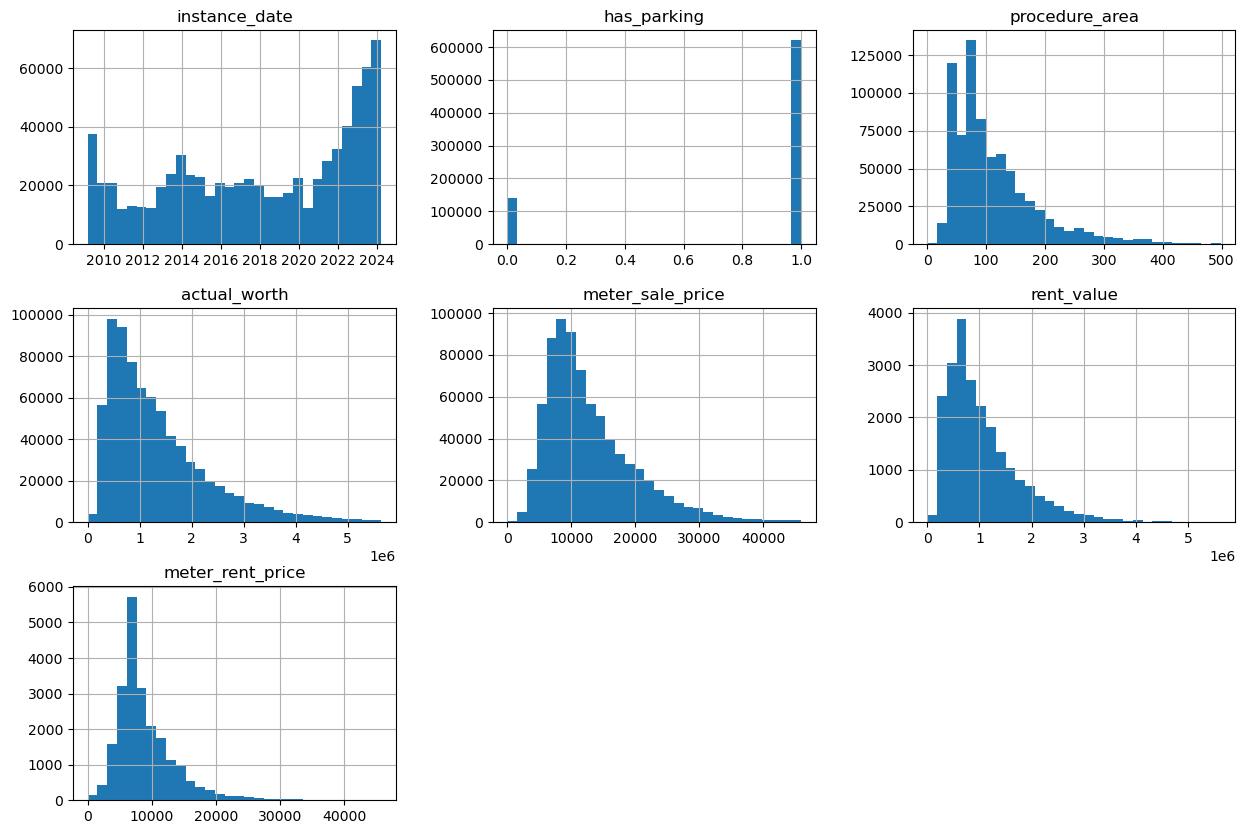

In [19]:
data.hist(bins=30, figsize=(15, 10))
plt.show()

## Handling Missing Values


### Visualize missing values

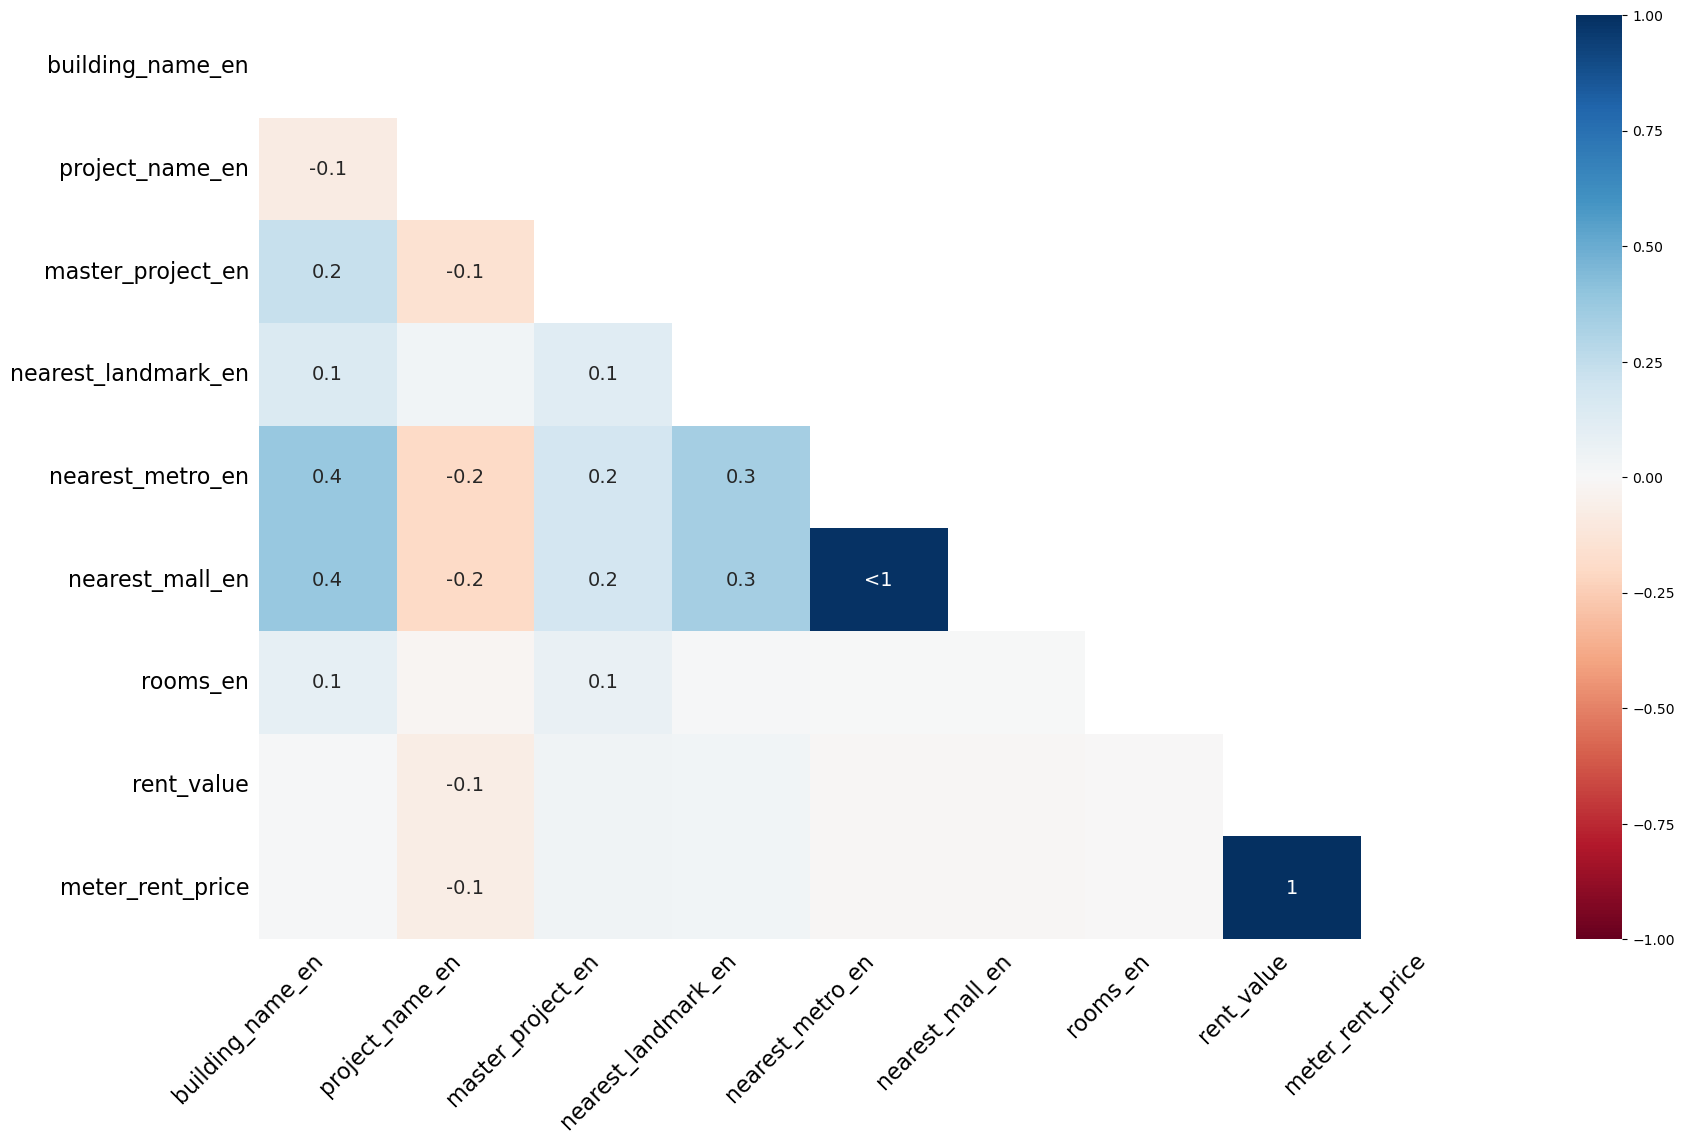

In [20]:
msno.heatmap(data)  # Heatmap visualization to check the correlation between missing values

plt.show()

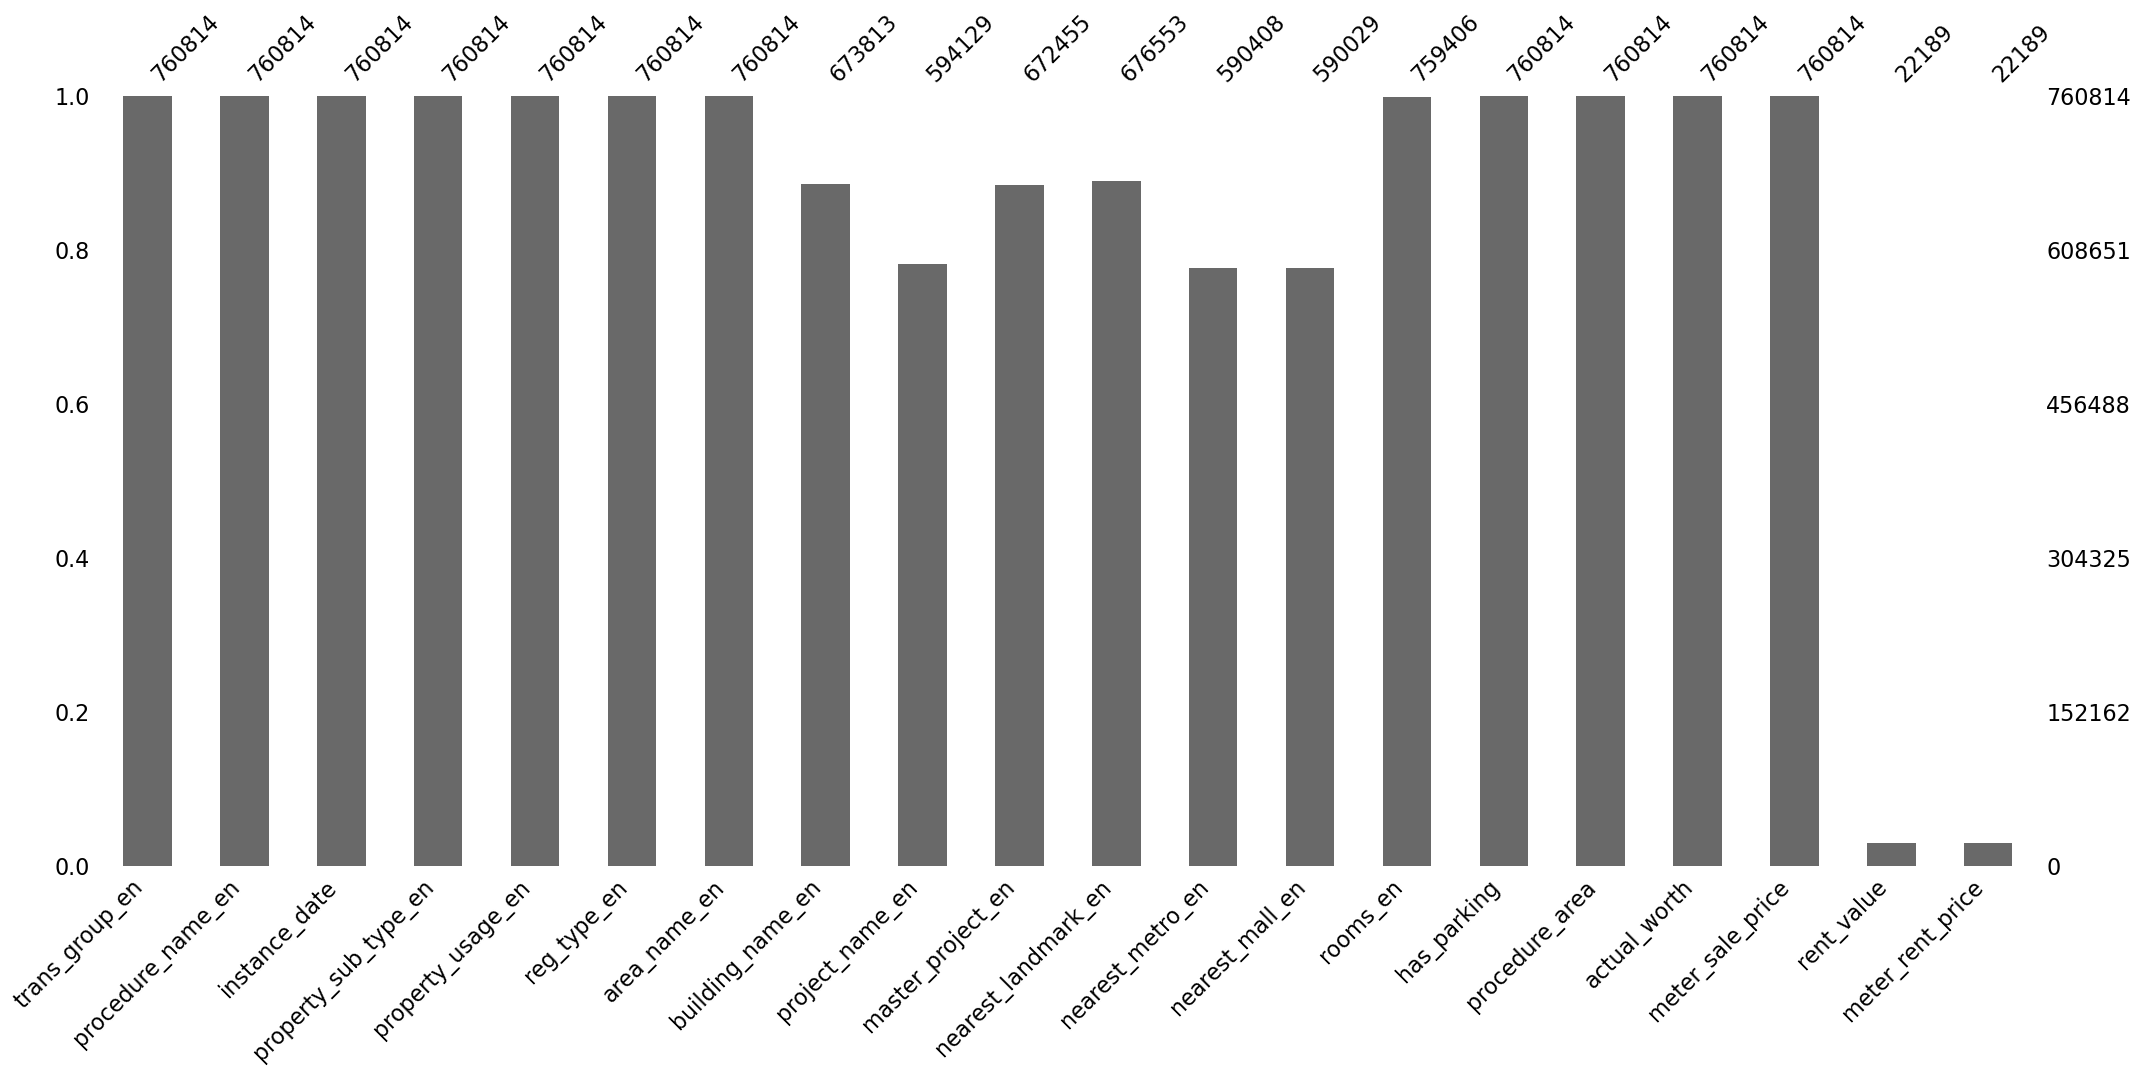

In [21]:
msno.bar(data)  # Bar chart visualization to check the number of missing values in each feature

plt.show()

<Axes: >

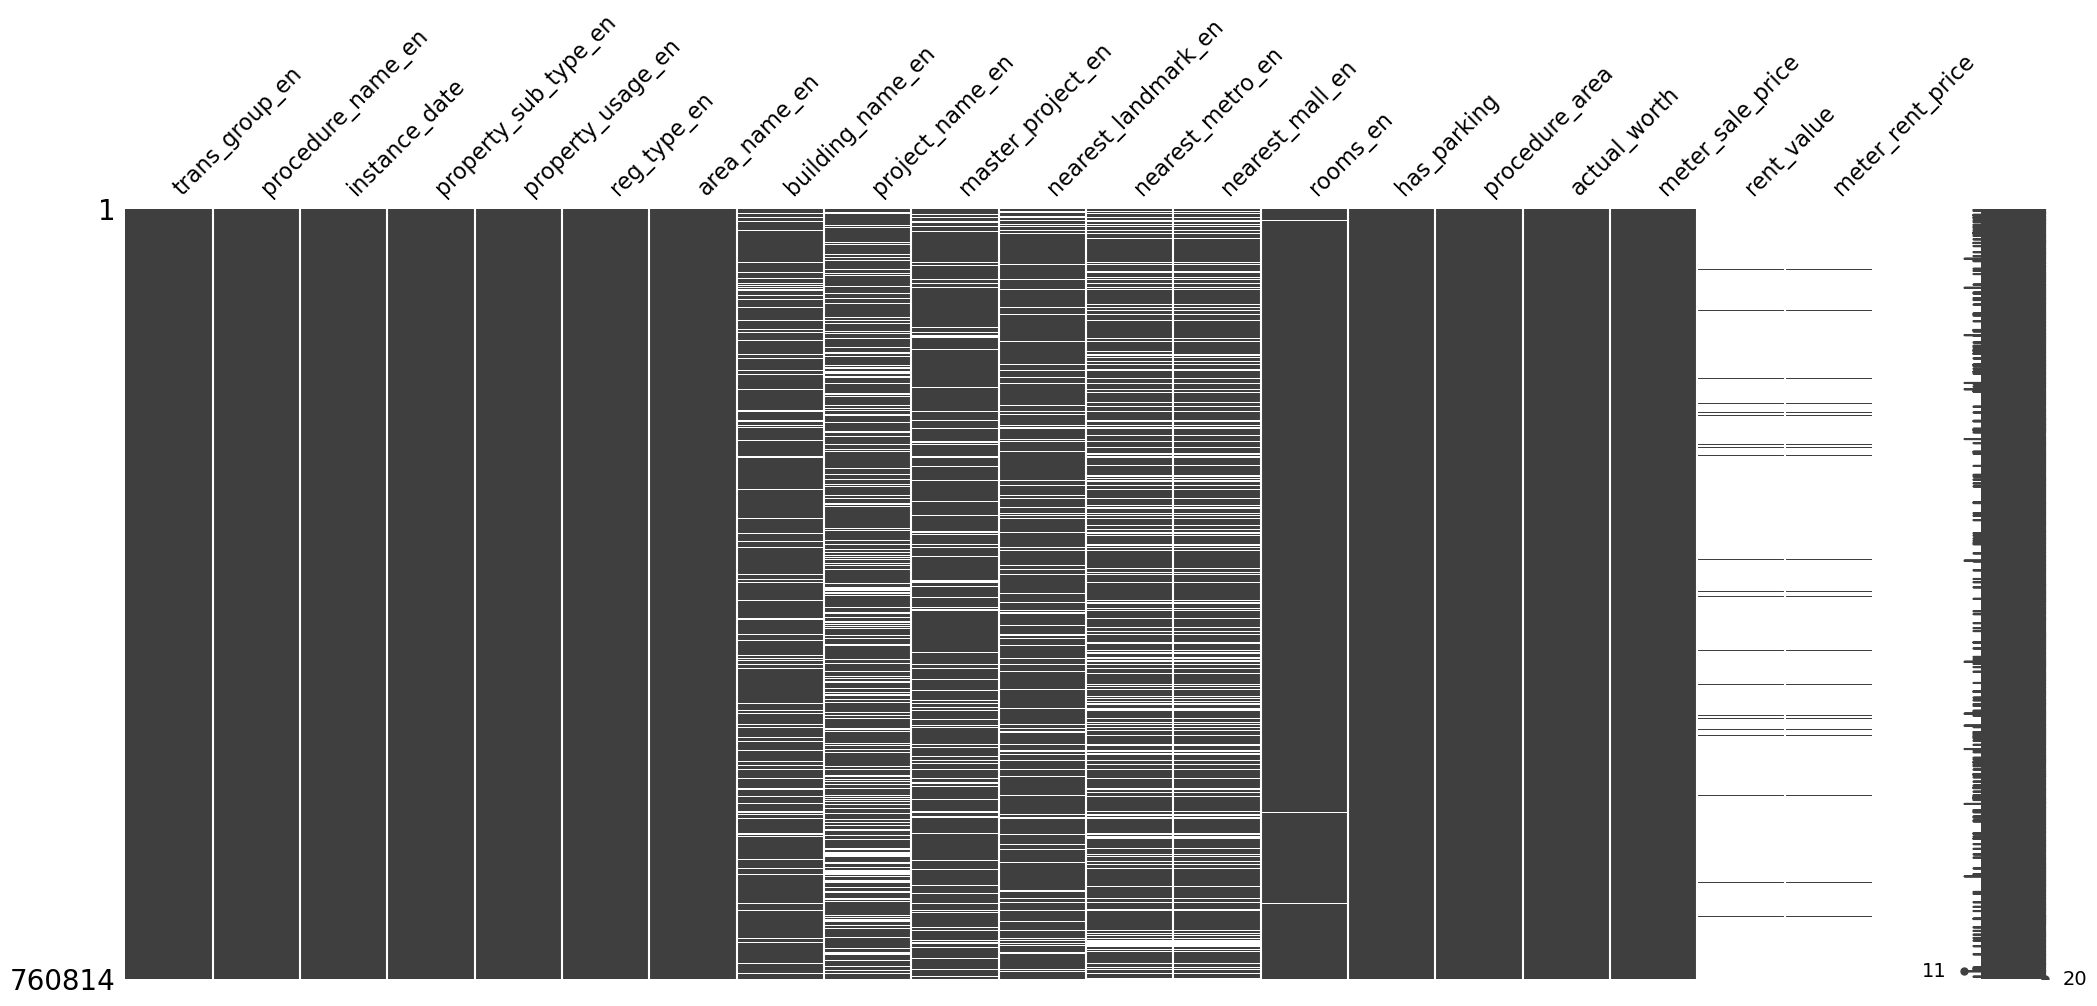

In [22]:
msno.matrix(data)

In [23]:
def missing_values_percentage(input_df):
    # Get the total number of rows in the DataFrame
    total_rows = input_df.shape[0]
    
    # Calculate the number of missing values per feature
    missing_values_count = input_df.isnull().sum()
    
    # Calculate the percentage of missing values per feature
    missing_values_percentage = (missing_values_count / total_rows) * 100
    
    # Create a DataFrame to store the results
    missing_df = pd.DataFrame({
        'column_name': missing_values_percentage.index,
        'missing_count': missing_values_count.values,
        'missing_ratio': missing_values_percentage.values
    })
    
    # Filter out features with missing ratio greater than 0%
    missing_df = missing_df[missing_df['missing_ratio'] > 0]
    
    return missing_df

In [24]:
print("Statistics of missing values per feature:")
print(missing_values_percentage(data))

Statistics of missing values per feature:
            column_name  missing_count  missing_ratio
7      building_name_en          87001         11.435
8       project_name_en         166685         21.909
9     master_project_en          88359         11.614
10  nearest_landmark_en          84261         11.075
11     nearest_metro_en         170406         22.398
12      nearest_mall_en         170785         22.448
13             rooms_en           1408          0.185
18           rent_value         738625         97.084
19     meter_rent_price         738625         97.084


In [25]:
def print_category_summary(category):
    values = data[category].value_counts()
    print(f"Lenght: {values.shape[0]} \n")
    print(values)

    missing = data[category].isna().sum()
    print(f"\nmissing: {missing}")

In [26]:
# Analyze categorical data
categorical_cols = data.select_dtypes(include=['object']).columns

for col in categorical_cols:
    print_category_summary(col)

Lenght: 2 

sales        630319
mortgages    130495
Name: trans_group_en, dtype: int64

missing: 0
Lenght: 35 

sell_-_pre_registration                       300173
sell                                          245062
mortgage_registration                          82533
delayed_sell                                   44423
lease_to_own_registration                      35276
development_registration                        6954
delayed_mortgage                                6895
lease_to_own_registration_pre-registration      6044
sell_development                                6043
lease_finance_registration                      4885
mortgage_pre-registration                       4808
modify_mortgage                                 4411
development_registration_pre-registration       3270
development_mortgage                            2839
mortgage_transfer                               1527
delayed_development                             1158
sale_on_payment_plan                    

In [27]:
columns_to_drop = [ 'rent_value', # 97% of missing values
                   'meter_rent_price', # 97% of missing values
                   'meter_sale_price', # feature is derived from 'actual_worth'
                   'building_name_en', # dropped because of too many categories. missing: 87001, Length: 3195
                   'project_name_en', # dropped because of too many categories. missing: 166685, Length: 1544
                   'instance_date'] # not important for defined model

# Reset indices
# After data cleaning the indices refer to  all data (including the removed observations)
data_cleaned = data.drop(columns_to_drop, axis=1).reset_index(drop=True)

## Feature Engineering

### Perform Imputing for the 'rooms_en' column with the RandomForestClassifier
Implementing imputation with a predictive model involves training a machine learning model to predict missing values based on other features in the dataset. 

**Plan**:
1. Split the dataset between rows with the column 'rooms_en' filled in, and rows with null values.
2. Train the classification model with the rooms_en as target feature utilising the first dataframe
3. Use the model trained to predict the missing values from the dataframe with null values
4. Merge the two dataframe into one

In [28]:
# Define categorical and numerical features

categorical_cols = data_cleaned.drop(['rooms_en'],axis=1).select_dtypes(include=['object']).columns
numerical_cols = data_cleaned.select_dtypes(include=['number']).columns

categorical_encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')  # 'ignore' handle_unknown ignores unknown categories in test data

# Define preprocessing steps for numerical and categorical columns to encode and scale Independent Variables
numerical_preprocessing = Pipeline(steps=[
    ('scaler', StandardScaler())
])

categorical_preprocessing = Pipeline(steps=[
    ('encoder', categorical_encoder)
])

# Create preprocessor for categorical and numerical variables
preprocessor = ColumnTransformer(
    transformers=[
    ('num', numerical_preprocessing, numerical_cols),
    ('cat', categorical_preprocessing, categorical_cols)
    ],
    remainder='passthrough', 
    verbose=True)

**Split the dataset**

In [29]:
# split the dataset between rows with the column rooms_en, and rows with null values.

df_with_rooms = data_cleaned[data_cleaned['rooms_en'].notna()]
print("N. rows with rooms_en not null:", df_with_rooms.shape[0])

df_no_rooms = data_cleaned[data_cleaned['rooms_en'].isna()]
print("N. rows with rooms_en null:", df_no_rooms.shape[0])
# N. rows with rooms_en not null: 759406
# N. rows with rooms_en null: 1408

N. rows with rooms_en not null: 759406
N. rows with rooms_en null: 1408


In [30]:
df_with_rooms.head()

,trans_group_en,procedure_name_en,property_sub_type_en,property_usage_en,reg_type_en,area_name_en,master_project_en,nearest_landmark_en,nearest_metro_en,nearest_mall_en,rooms_en,has_parking,procedure_area,actual_worth
0,sales,sell,flat,residential,existing_properties,burj_khalifa,burj_khalifa,burj_khalifa,buj_khalifa_dubai_mall_metro_station,dubai_mall,1_bedroom,1,89.930,2008888.000
1,sales,sell,flat,residential,existing_properties,al_thanyah_fifth,jumeirah_lakes_towers,burj_al_arab,damac_properties,marina_mall,1_bedroom,1,100.800,928756.000
2,sales,lease_to_own_registration,flat,residential,existing_properties,al_warsan_first,international_city_phase_1,dubai_international_airport,rashidiya_metro_station,city_centre_mirdif,studio,0,43.000,290000.000
3,sales,sell,flat,residential,existing_properties,me'aisem_first,international_media_production_zone,sports_city_swimming_academy,damac_properties,marina_mall,studio,1,47.650,519000.000
4,sales,sell,flat,residential,existing_properties,marsa_dubai,jumeriah_beach_residence__-_jbr,burj_al_arab,jumeirah_beach_resdency,marina_mall,3_bedroom,1,178.520,699000.000


**Train the classification model**

In [31]:
# train the classification model

X = df_with_rooms.drop(['rooms_en',], axis=1)
y = df_with_rooms["rooms_en"]

X_train, X_test, Y_train, Y_test = train_test_split(X, y, test_size=0.1, random_state=0)

model = RandomForestClassifier(n_estimators=45, max_depth=25, random_state=False, 
                                max_features=0.6, min_samples_leaf=3, n_jobs=-1, verbose=1)

# Create a pipeline
forest = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', model)
])

forest.fit(X_train, Y_train)

[ColumnTransformer] ........... (1 of 2) Processing num, total=   0.0s
[ColumnTransformer] ........... (2 of 2) Processing cat, total=   6.5s


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:  5.4min finished


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('num',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  Index(['has_parking', 'procedure_area', 'actual_worth'], dtype='object')),
                                                 ('cat',
                                                  Pipeline(steps=[('encoder',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  Index(['trans_group_en', 'procedure_name_en', 'property_sub_type_en',
       'property_usage_en', 'reg_type_en', 'area_name_en', 'master_project_en',
       'nearest_landmark_en', 'nearest_metro_en', 'nearest_mall_en'],
      dtype='object'))],
                                   verbose=True)),
                ('model',
                 RandomForestClassifier(max_depth=25, max_features=0.6,
                                        min_samples_leaf=3, n_estimators=45,
                                        n_jobs=-1, random_state=False,
                                        verbose=1))])

In [32]:
# Evaluate the model
y_pred_train = forest.predict(X_train)
y_pred = forest.predict(X_test)

y_pred_proba = forest.predict_proba(X_test)

accuracy_train = accuracy_score(Y_train, y_pred_train)
accuracy_test = accuracy_score(Y_test, y_pred)

print("ACCURACY: TRAIN=%.4f TEST=%.4f" % (accuracy_train, accuracy_test))
print("LOG LOSS: "+str(log_loss(Y_test, y_pred_proba)))

[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  45 out of  45 | elapsed:    3.3s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  45 out of  45 | elapsed:    0.4s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  45 out of  45 | elapsed:    0.4s finished


ACCURACY: TRAIN=0.9653 TEST=0.9556
LOG LOSS: 0.14064641023265614


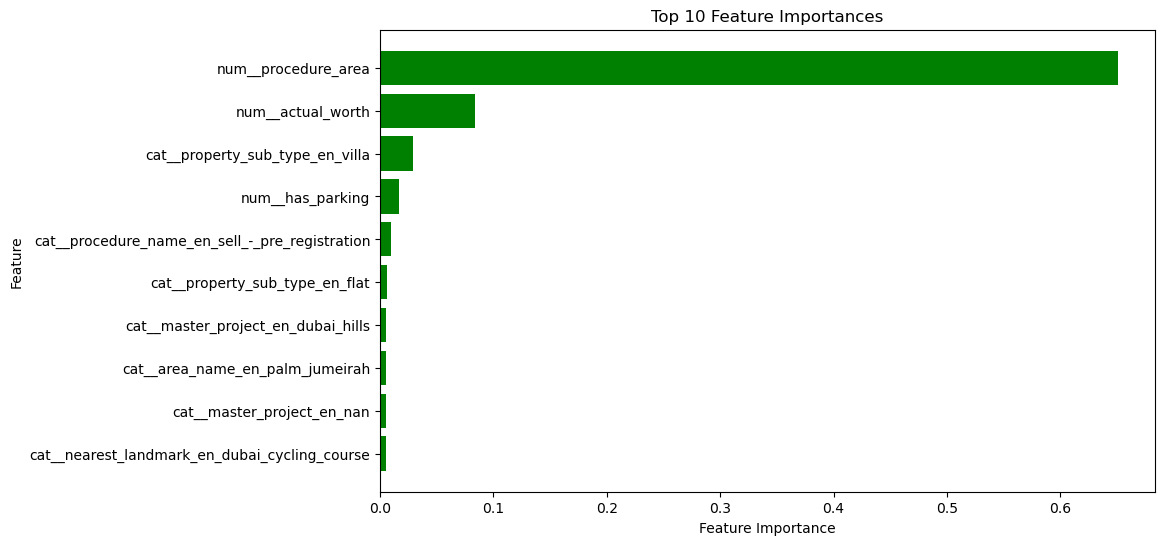

In [33]:
# Visualise top 10 features importances

importances = forest.named_steps['model'].feature_importances_
indices = list(np.argsort(importances))[::-1]

# Get the feature names after encoding (without prefixes)
encoded_feature_names = forest.named_steps['preprocessor'].get_feature_names_out()

# Get the indices of the top features
top_feature_indices = indices[:10]

# Get the top feature importances and names
top_importances = importances[top_feature_indices]
top_feature_names = encoded_feature_names[top_feature_indices]

# Plot top 10 importances
plt.figure(figsize=(10, 6))
plt.title("Top 10 Feature Importances")
plt.barh(range(len(top_feature_indices)), top_importances, color="g", align="center")
plt.yticks(range(len(top_feature_indices)), top_feature_names)
plt.xlabel("Feature Importance")
plt.ylabel("Feature")
plt.gca().invert_yaxis()
plt.show()

**Predict missing values in 'rooms_en'**

In [34]:
# Fill the 2nd dataframe with the values of the prediction

df_no_rooms = df_no_rooms.drop('rooms_en', axis=1)
prediction = forest.predict(df_no_rooms)

df_no_rooms.insert(0, 'rooms_en', prediction)

[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  45 out of  45 | elapsed:    0.0s finished


**Merge dataframes**

In [35]:
# Merge the dataframes
frames = [df_with_rooms, df_no_rooms]
df_final = pd.concat(frames)

In [36]:
df_final.head()

,trans_group_en,procedure_name_en,property_sub_type_en,property_usage_en,reg_type_en,area_name_en,master_project_en,nearest_landmark_en,nearest_metro_en,nearest_mall_en,rooms_en,has_parking,procedure_area,actual_worth
0,sales,sell,flat,residential,existing_properties,burj_khalifa,burj_khalifa,burj_khalifa,buj_khalifa_dubai_mall_metro_station,dubai_mall,1_bedroom,1,89.930,2008888.000
1,sales,sell,flat,residential,existing_properties,al_thanyah_fifth,jumeirah_lakes_towers,burj_al_arab,damac_properties,marina_mall,1_bedroom,1,100.800,928756.000
2,sales,lease_to_own_registration,flat,residential,existing_properties,al_warsan_first,international_city_phase_1,dubai_international_airport,rashidiya_metro_station,city_centre_mirdif,studio,0,43.000,290000.000
3,sales,sell,flat,residential,existing_properties,me'aisem_first,international_media_production_zone,sports_city_swimming_academy,damac_properties,marina_mall,studio,1,47.650,519000.000
4,sales,sell,flat,residential,existing_properties,marsa_dubai,jumeriah_beach_residence__-_jbr,burj_al_arab,jumeirah_beach_resdency,marina_mall,3_bedroom,1,178.520,699000.000


## Modeling

### Define Pipeline with transformers for categorical and numerical data

In [38]:
# Define X and y
X = df_final.drop(['actual_worth'], axis=1)
y = df_final['actual_worth']

# Define categorical and numerical values
categorical_cols = X.select_dtypes(include=['object']).columns
numerical_cols = X.select_dtypes(include=['number']).columns

# Define preprocessing steps for numerical and categorical columns
numerical_preprocessing = Pipeline(steps=[
    ('scaler', StandardScaler())
])

categorical_preprocessing = Pipeline(steps=[
    ('encoder', OneHotEncoder(handle_unknown='ignore')),
])

# Combine preprocessing steps for numerical and categorical columns
preprocessor = ColumnTransformer(
    transformers=[
    ('num', numerical_preprocessing, numerical_cols),
    ('cat', categorical_preprocessing, categorical_cols)
    ],
    remainder='passthrough', 
    verbose=True)

### Train the model

In [39]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 50% for testing and 50% for validation
X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, test_size = 0.5) 

# Define XGBoost Regressor model
model = XGBRegressor(objective='reg:squarederror', learning_rate=0.1, max_depth=30, n_estimators=100)

# Create a pipeline
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', model)
])

# Fit the pipeline on the training data
pipeline.fit(X_train, y_train)

# Evaluate the model
score = pipeline.score(X_test, y_test)
print("Model Score:", score)

[ColumnTransformer] ........... (1 of 2) Processing num, total=   0.0s
[ColumnTransformer] ........... (2 of 2) Processing cat, total=   4.5s
Model Score: 0.8494678494792041


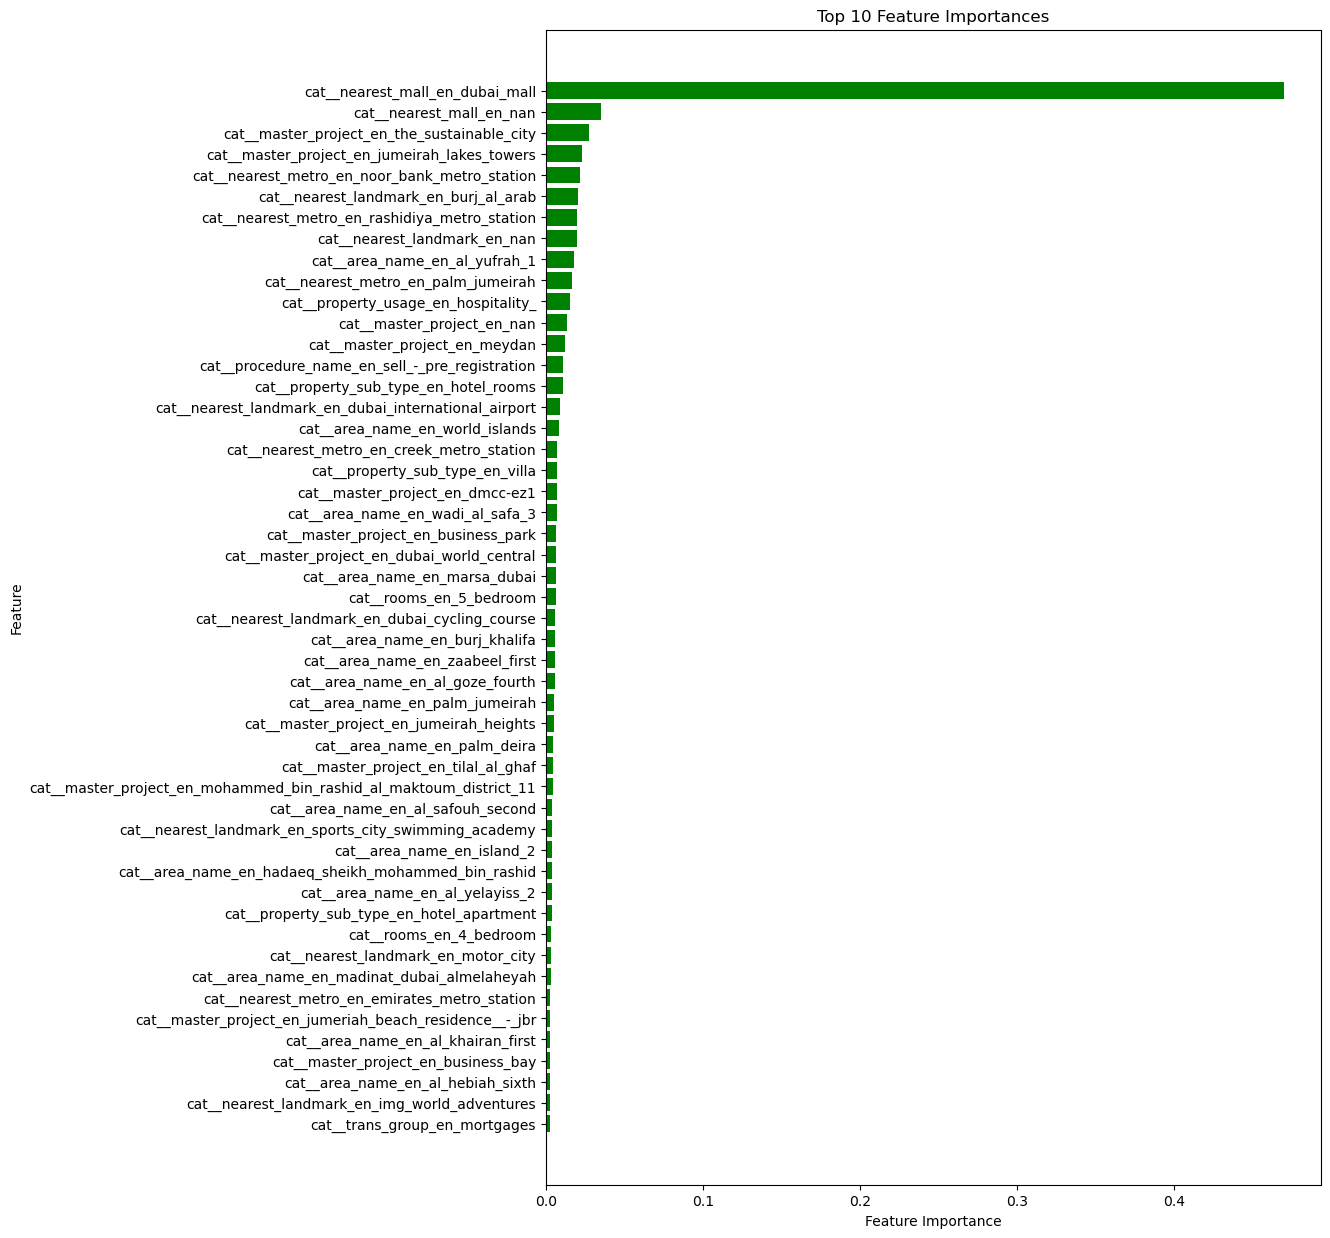

In [40]:
# Visualise top 10 features importances

importances = pipeline.named_steps['model'].feature_importances_
indices = list(np.argsort(importances))[::-1]

# Get the feature names after encoding (without prefixes)
encoded_feature_names = pipeline.named_steps['preprocessor'].get_feature_names_out()

# Get the indices of the top features
top_feature_indices = indices[:50]

# Get the top feature importances and names
top_importances = importances[top_feature_indices]
top_feature_names = encoded_feature_names[top_feature_indices]

# Plot top 10 importances
plt.figure(figsize=(10, 15))
plt.title("Top 10 Feature Importances")
plt.barh(range(len(top_feature_indices)), top_importances, color="g", align="center")
plt.yticks(range(len(top_feature_indices)), top_feature_names)
plt.xlabel("Feature Importance")
plt.ylabel("Feature")
plt.gca().invert_yaxis()
plt.show()

### Make predictions and evaluate the model

In [41]:
y_predict = pipeline.predict(X_test)

In [42]:
k = X_test.shape[1]
n = len(X_test)
RMSE = float(format(np.sqrt(mean_squared_error(y_test, y_predict)),'.3f'))
MSE = mean_squared_error(y_test, y_predict)
MAE = mean_absolute_error(y_test, y_predict)
# coefficient of determination - how much variance can be explained by the given features
r2 = r2_score(y_test, y_predict)
# adjusted R-squared - adjusts for the degrees of freedom, effectively penalizing the addition of more predictors to a model
adj_r2 = 1-(1-r2)*(n-1)/(n-k-1)

print('RMSE =',RMSE, '\nMSE =',MSE, '\nMAE =',MAE, '\nR2 =', r2, '\nAdjusted R2 =', adj_r2) 

RMSE = 379962.04 
MSE = 144371151657.74658 
MAE = 225935.33499904387 
R2 = 0.8494678494792041 
Adjusted R2 = 0.8494421232384325


# Hyperparameter Tuning with Sagemaker

## Save data to S3

In [ ]:
# Initial Settings

import sagemaker
import boto3
from sagemaker import Session

# create a Sagemaker session
sagemaker_session = sagemaker.Session(default_bucket='dld-transactions')
bucket = 'dld-transactions'
region = boto3.Session().region_name
role = sagemaker.get_execution_role()

# S3 prefixes
prefix = 'XGBoost-Regressor'
key = 'data'

In [ ]:
# Loading training data to S3

train_df = pd.DataFrame(X_train)
train_df.insert(0, 'Target', y_train)

In [ ]:
# Loading validation data to S3

val_df = pd.DataFrame(X_val)
val_df.insert(0, 'Target', y_val)

In [ ]:
# Loading test data to S3

test_df = pd.DataFrame(X_test)
test_df.insert(0, 'Target', y_test)

In [ ]:
# save data as csv files
train_df.to_csv('train.csv', header = False, index=False)
val_df.to_csv('validation.csv', header = False, index = False)
test_df.to_csv('test.csv', header = False, index = False)

In [ ]:
# read the data from csv file and then upload the data to s3 bucket
import os
with open('train.csv','rb') as f:
    # The following code uploads the data into S3 bucket to be accessed later for training
    boto3.Session().resource('s3').Bucket(bucket).Object(os.path.join(prefix, 'train', key)).upload_fileobj(f)

# print out the training data location in s3
s3_train_data = 's3://{}/{}/train/{}'.format(bucket, prefix, key)
print('uploaded training data location: {}'.format(s3_train_data))

In [ ]:
# read the data from csv file and then upload the data to s3 bucket

with open('validation.csv','rb') as f:
    # The following code uploads the data into S3 bucket to be accessed later for training

    boto3.Session().resource('s3').Bucket(bucket).Object(os.path.join(prefix, 'validation', key)).upload_fileobj(f)
# Let's print out the validation data location in s3
s3_validation_data = 's3://{}/{}/validation/{}'.format(bucket, prefix, key)
print('uploaded validation data location: {}'.format(s3_validation_data))

In [ ]:
# creates output placeholder in S3 bucket to store the output

output_location = 's3://{}/{}/output'.format(bucket, prefix)
print('training artifacts will be uploaded to: {}'.format(output_location))

In [ ]:
# Obtain a reference to the XGBoost container image (sagemaker built-in algorithm)

container = sagemaker.image_uris.retrieve('xgboost',boto3.Session().region_name,'1.7-1') # Latest version of XGboost

In [ ]:
from sagemaker.estimator import Estimator
from sagemaker.image_uris import retrieve as model_image

job_name = "dal-transactions-xgboost-v2" # Training job name
output_location = 's3://{}/{}/artifacts/'.format(bucket, prefix) # S3 output path to place trained model artifacts

# Returns image from XG-Boost algorithm
image = model_image(region = region, framework = "xgboost", version = "1.0-1")

# Creating the estimator
estimator = Estimator(
    sagemaker_session = sagemaker_session,
    image_uri = container,
    base_job_name = job_name,
    role = role,
    output_path = output_location,
    instance_type = 'ml.m4.xlarge',
    instance_count = 2,
    use_spot_instances = True,
    max_run = 4000,
    max_wait = 8000
)


In [ ]:
# Instead of parsing a list of values for hyperparameter option, 
# the search grid is set to declare a range space where the tuning job itself 
# will be allowed to select values to test.

from sagemaker.tuner import ContinuousParameter, IntegerParameter

search_grid = {
    "alpha": ContinuousParameter(1, 20),
    "eta": ContinuousParameter(0.1, 0.5),
    "max_depth": IntegerParameter(5, 25),
    "colsample_bytree": ContinuousParameter(0.1, 0.5),
}


In [ ]:
# Create the hyperparameter tuning job class

from sagemaker.tuner import HyperparameterTuner

# Estimator objective and evaluation metric to be applied
estimator.set_hyperparameters(
    eval_metric = 'rmse',
    objective = 'reg:squarederror',
    num_round = 400,
    rate_drop = 0.3
)


# Creating a tuner class
hyperparam_tuner = HyperparameterTuner(
    estimator = estimator,
    early_stopping_type = "Auto",
    objective_metric_name = 'validation:rmse',
    strategy = "Bayesian", # The HyperparameterTuner() class optimizes the searching of values to be tested on each model training using Bayesian Search. This method treats this whole value searching task as a regression problem.
    objective_type = "Minimize",
    max_jobs = 10,
    max_parallel_jobs = 2,
    hyperparameter_ranges = search_grid
)

In [ ]:
from sagemaker.inputs import TrainingInput

# Start execution
hyperparam_tuner.fit(
    wait = False,
    job_name = job_name,
    inputs = {
        "train": TrainingInput(s3_train_data, content_type = "csv"), 
        "validation": TrainingInput(s3_validation_data, content_type = "csv")
    }
)

In [ ]:
import boto3

# Create client from sagemaker service
client = boto3.Session().client("sagemaker")

# Get tuning job description
tuner_job_info = client.describe_hyper_parameter_tuning_job(
  HyperParameterTuningJobName = job_name
)

# Get name from the best training job among all jobs performed
best_job_name = tuner_job_info["BestTrainingJob"]["TrainingJobName"]

# Get best job description
best_job_info = client.describe_training_job(
  TrainingJobName = best_job_name
)

In [ ]:
print('Best Job: {}'.format(best_job_name))
print('Status: {}'.format(best_job_info['TrainingJobStatus']))
print('Metric Value: {}'.format(best_job_info['FinalMetricDataList'][-1]['Value']))
print('Artifact Path: {}'.format(best_job_info['ModelArtifacts']['S3ModelArtifacts']))

In [64]:
# Define XGBoost Regressor model with tuned hyperparameters
model_tuned = XGBRegressor(objective='reg:squarederror',
                           alpha=1,
                           colsample_bytree=0.8,
                           eta=0.3373527874937141,
                           max_depth=10, 
                           min_child_weight=5,
                           gamma = 0.8,
                           n_estimators=1000)

# Create a pipeline
pipeline_tuned = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', model_tuned)
])

# Fit the pipeline on the training data
pipeline_tuned.fit(X_train, y_train)

# Evaluate the model
score_tuned = pipeline_tuned.score(X_test, y_test)
print("Model Score:", score_tuned)

[ColumnTransformer] ........... (1 of 2) Processing num, total=   0.0s
[ColumnTransformer] ........... (2 of 2) Processing cat, total=   4.4s


/home/ec2-user/anaconda3/envs/tensorflow2_p310/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [17:27:07] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "num_round" } are not used.

  warnings.warn(smsg, UserWarning)


Model Score: 0.8560291387158773


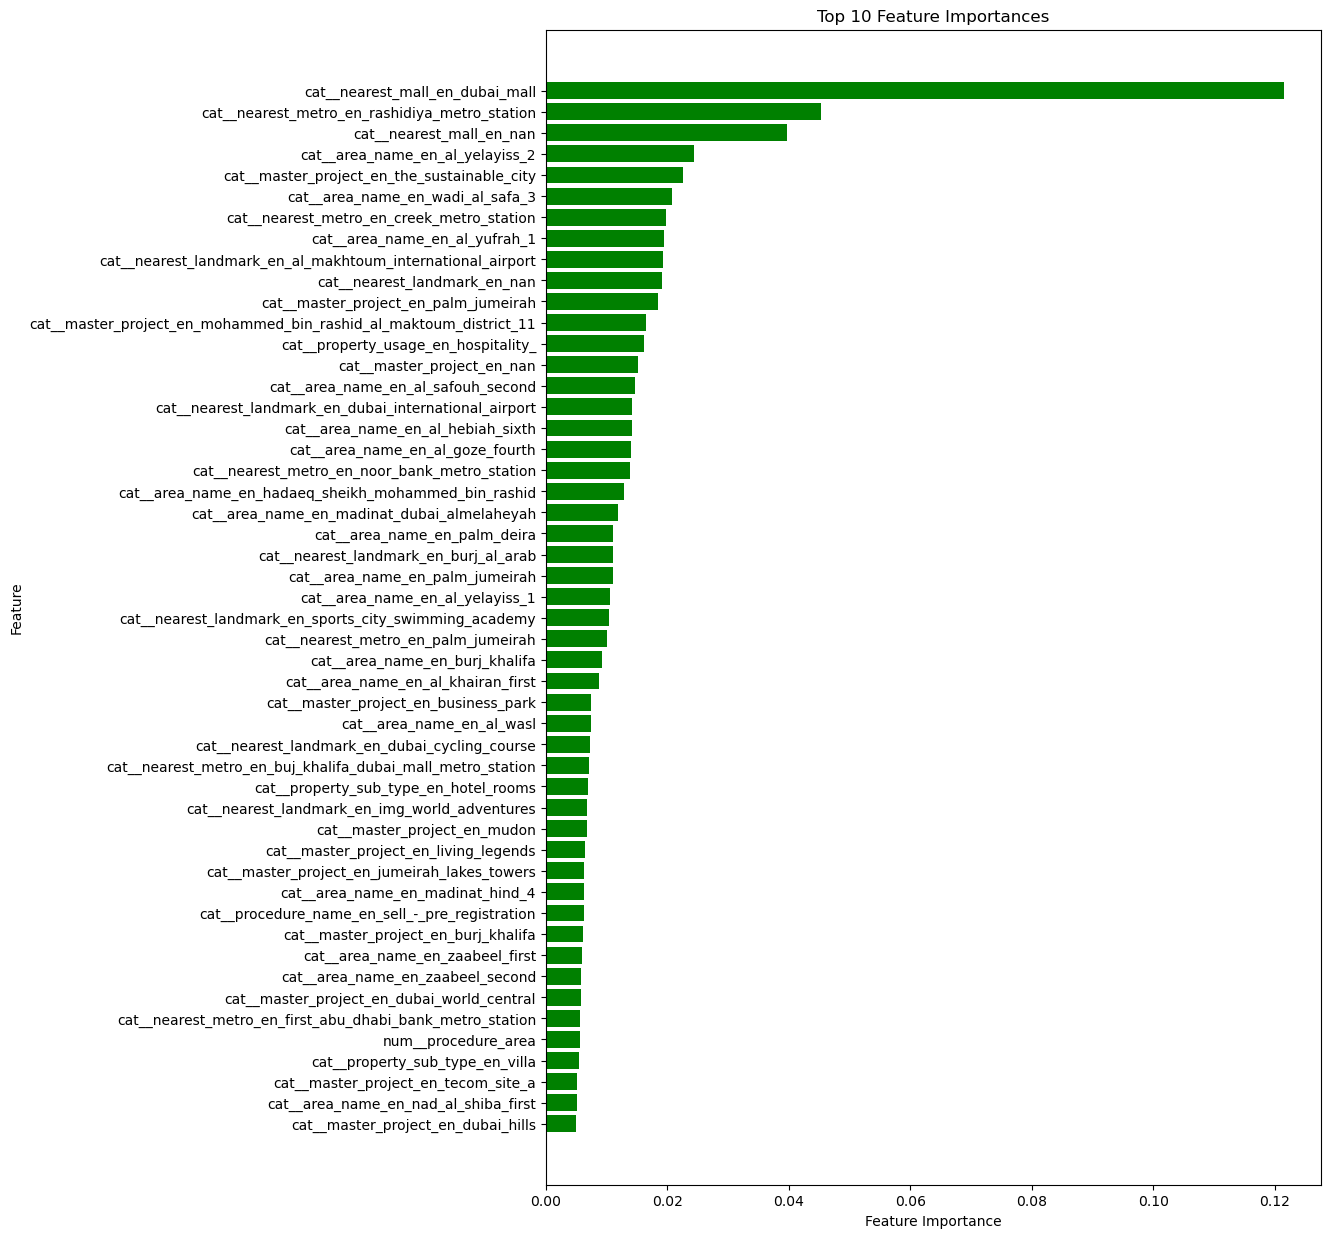

In [57]:
# Visualise top 10 features importances

importances = pipeline_tuned.named_steps['model'].feature_importances_
indices = list(np.argsort(importances))[::-1]

# Get the feature names after encoding (without prefixes)
encoded_feature_names = pipeline_tuned.named_steps['preprocessor'].get_feature_names_out()

# Get the indices of the top features
top_feature_indices = indices[:50]

# Get the top feature importances and names
top_importances = importances[top_feature_indices]
top_feature_names = encoded_feature_names[top_feature_indices]

# Plot top 10 importances
plt.figure(figsize=(10, 15))
plt.title("Top 10 Feature Importances")
plt.barh(range(len(top_feature_indices)), top_importances, color="g", align="center")
plt.yticks(range(len(top_feature_indices)), top_feature_names)
plt.xlabel("Feature Importance")
plt.ylabel("Feature")
plt.gca().invert_yaxis()
plt.show()

In [45]:
y_predict = pipeline_tuned.predict(X_test)

In [46]:
k = X_test.shape[1]
n = len(X_test)
RMSE = float(format(np.sqrt(mean_squared_error(y_test, y_predict)),'.3f'))
MSE = mean_squared_error(y_test, y_predict)
MAE = mean_absolute_error(y_test, y_predict)

# coefficient of determination - how much variance can be explained by the given features
r2 = r2_score(y_test, y_predict)
# adjusted R-squared - adjusts for the degrees of freedom, effectively penalizing the addition of more predictors to a model
adj_r2 = 1-(1-r2)*(n-1)/(n-k-1)

print('RMSE =',RMSE, '\nMSE =',MSE, '\nMAE =',MAE, '\nR2 =', r2, '\nAdjusted R2 =', adj_r2) 

RMSE = 371538.223 
MSE = 138040650996.62274 
MAE = 223828.30406503944 
R2 = 0.8560685025006013 
Adjusted R2 = 0.8560439043244212
